In [74]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import pandas as pd
from scipy.optimize import minimize

import edhec_risk_kit_129 as erk

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Efficient Frontier

In [14]:
ind = pd.read_csv('data/ind30_m_vw_rets.csv', header=0, index_col=0, parse_dates=True) / 100

In [15]:
ind.index = pd.to_datetime(ind.index, format="%Y%m")
# need to trim spaces
ind.columns=ind.columns.str.strip()

<AxesSubplot:>

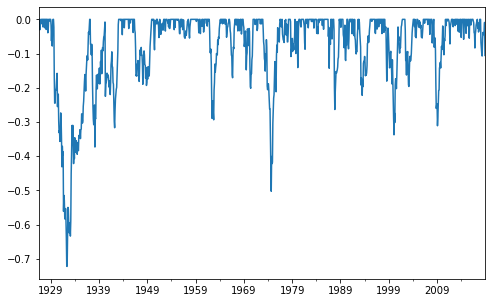

In [18]:
erk.drawdown(ind['Food'])['Drawdown'].plot.line(figsize = (8,5))

In [22]:
cols_of_interest = ['Food', 'Smoke', 'Coal', 'Beer', 'Fin']
erk.var_gaussian(ind[cols_of_interest], modified=True).sort_values()

Beer     0.033881
Coal     0.047359
Food     0.061207
Fin      0.075199
Smoke    0.080292
dtype: float64

<AxesSubplot:>

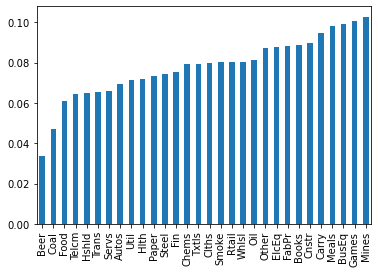

In [24]:
erk.var_gaussian(ind, modified=True).sort_values().plot.bar()

<AxesSubplot:>

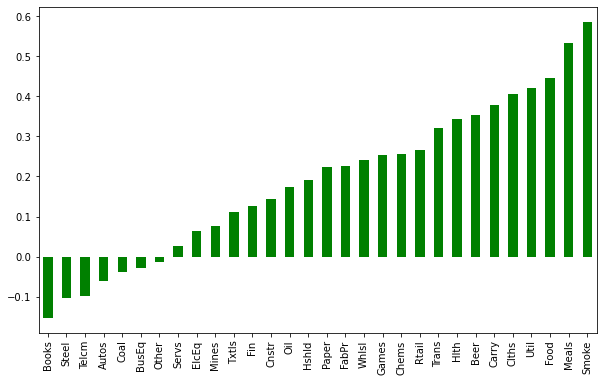

In [28]:
erk.sharpe_ratio(ind['2000':], 0.03, 12).sort_values().plot.bar(figsize = (10,6), color='green')

In [34]:
er = erk.annualize_rets(ind['1996':'2000'], 12)
cov = ind['1996':'2000'].cov()

$R_p = w^TR$  
$\sigma_p^2 = w^T\Sigma w$, where $\Sigma$ is the covariance matrix  

$\min \frac{1}{2} w^T\Sigma w$  
subject to  
$w^T R = r_0$  
$w^T 1 = 1$  
$w ≥ 0$  

In [30]:
def portfolio_return(weights, returns):
    return weights.T @ returns

def portfolio_vol(weights, covmat):
    return weights.T@covmat@weights ** 0.5

In [35]:
l = ['Food', 'Beer', 'Smoke', 'Coal']
er[l]

Food     0.116799
Beer     0.141126
Smoke    0.107830
Coal     0.414689
dtype: float64

In [36]:
cov.loc[l,l]

Food      Beer     Smoke      Coal
Food   0.002609  0.002379  0.002061  0.000027
Beer   0.002379  0.005264  0.001359  0.001728
Smoke  0.002061  0.001359  0.008349 -0.000733
Coal   0.000027  0.001728 -0.000733  0.018641

In [37]:
weights = np.repeat(1/4,4)
print(erk.portfolio_return(weights, er[l]))
print(erk.portfolio_vol(weights, cov.loc[l,l]))

0.19511097196038385
0.055059195776437045


#### 2 Asset Frontier

<AxesSubplot:xlabel='Vol'>

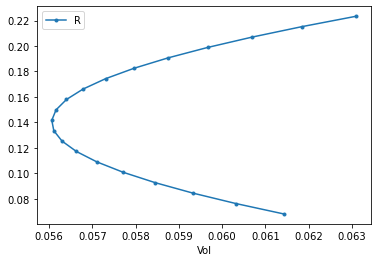

In [46]:
l = ['Games', 'Fin']
n_points = 20
weights = [np.array([w,1-w]) for w in np.linspace(0,1,n_points)]

# returns and vols
rets = [erk.portfolio_return(w, er[l]) for w in weights]
vols = [erk.portfolio_vol(w, cov.loc[l,l]) for w in weights]
ef = pd.DataFrame({'R':rets, 'Vol':vols})
ef.plot.line(x='Vol', y = 'R', style='.-')

#### N Asset Efficient Frontier

In [55]:
# weights = minimize_vol(target_return)
# max return, min return and returns in between
def minimize_vol(target_return, er, cov):
    n = er.shape[0]
    init_guess = np.repeat(1/n, n)
    
    # constraints
    bounds = ((0.0, 1.0), ) * n # tuple of tuples
    return_is_target = {
        'type' : 'eq',
        'args': (er,),
        'fun': lambda weights, er : target_return - erk.portfolio_return(weights, er)
    }
    weights_sum_to_1 = {
        'type':'eq',
        'fun': lambda weights : np.sum(weights)-1
    }
    results = minimize(erk.portfolio_vol, 
                        init_guess, 
                      args = (cov,),
                      method = 'SLSQP',
                      options={'disp':False},
                      constraints=(return_is_target, weights_sum_to_1),
                      bounds=bounds)
    return results.x

In [56]:
w15 = minimize_vol(0.15,er[l], cov.loc[l,l])
vol15 = erk.portfolio_vol(w15, cov.loc[l,l])

In [57]:
vol15

0.056163669406706564

In [60]:
# list of weights to run optimization
target_rs = np.linspace(er.min(), er.max(), n_points)
weights = [minimize_vol(tr, er, cov) for tr in target_rs]

### Fund Separation Theorem and Capital Market Line

tangency portfolio is the max sharpe portfolio and has no exposure to specific risk.  



#### Max Sharpe Ratio Portfolio

In [64]:
# simple tweak from minimize_vol function
def msr(riskfree_rate, er, cov):
    n = er.shape[0]
    init_guess = np.repeat(1/n, n)    
    # constraints
    bounds = ((0.0, 1.0), ) * n # tuple of tuples
    weights_sum_to_1 = {
        'type':'eq',
        'fun': lambda weights : np.sum(weights)-1
    }
    
    def neg_sharpe_ratio(weights, riskfree_rate, er, cov):
        r = erk.portfolio_return(weights, er)
        vol = erk.portfolio_vol(weights, cov)
        return -(r-riskfree_rate)/vol
    
    results = minimize(neg_sharpe_ratio, 
                        init_guess, 
                      args = (riskfree_rate, er, cov, ),
                      method = 'SLSQP',
                      options={'disp':False},
                      constraints=(weights_sum_to_1),
                      bounds=bounds)
    return results.x

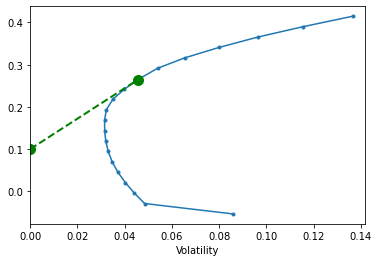

In [73]:
erk.plot_ef(20,er,cov, riskfree_rate=0.1, show_cml=True)

In [72]:
rf = 0.1
w_msr = msr(rf, er, cov)
r_msr = erk.portfolio_return(w_msr, er)
vol_msr = erk.portfolio_vol(w_msr, cov)

cml_x = [0,vol_msr]
cml_y = [rf, r_msr]
print(cml_x, cml_y)

[0, 0.045719731943639326] [0.1, 0.2647394815565282]


### Lack of Robustness of the Markowitz Procedure

In [76]:
l = ['Food', 'Steel']
erk.msr(0.1, er[l], cov.loc[l,l])

array([0.75040363, 0.24959637])

In [78]:
def gmv(cov):
    # returns the weights of the global minimum vol portfolio
    # have the optimizer minimize the vol
    n = cov.shape[0]
    return erk.msr(0,np.repeat(1,n), cov)

<AxesSubplot:xlabel='Volatility'>

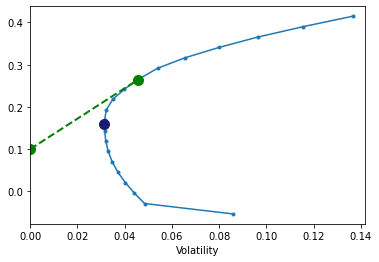

In [79]:
erk.plot_ef(20,er,cov, riskfree_rate=0.1, show_cml=True, show_gmv=True)